In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from model import get_model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
df_1 = pd.read_csv("data/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

train, test = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df[len(df.columns)-1])
train.shape, test.shape

((11641, 188), (2911, 188))

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,...,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000,14552.0,14552.000000
mean,0.976637,0.721663,0.403099,0.242893,0.207218,0.216453,0.221752,0.224486,0.227349,0.229704,...,0.001190,0.001133,0.000900,0.000739,0.000661,0.000475,0.000177,0.000185,0.0,0.721963
std,0.034532,0.195690,0.249794,0.249519,0.218097,0.192412,0.180740,0.176943,0.176674,0.176579,...,0.021361,0.021012,0.017316,0.014640,0.014033,0.012289,0.006545,0.006835,0.0,0.448047
min,0.624227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.959377,0.584589,0.212300,0.052269,0.061875,0.090487,0.096503,0.097095,0.097231,0.097144,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,1.000000,0.740148,0.371911,0.168148,0.136082,0.159451,0.167479,0.171541,0.177380,0.180337,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
75%,1.000000,0.881483,0.557785,0.336232,0.264104,0.264633,0.286484,0.302255,0.311664,0.325292,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985523,0.993213,0.997738,...,0.791899,0.773743,0.789804,0.628177,0.602033,0.644880,0.371502,0.376668,0.0,1.000000


In [6]:
len(df.columns), len(train)

(188, 11641)

In [7]:
df[len(df.columns)-1].value_counts()

1.0    10506
0.0     4046
Name: 187, dtype: int64

In [8]:
Y = np.array(train[len(train.columns)-1].values)
X = np.array(train[list(range(len(train.columns)-1))])[..., np.newaxis]

Y_test = np.array(test[len(train.columns)-1].values)
X_test = np.array(test[list(range(len(test.columns)-1))].values)[..., np.newaxis]

In [9]:
chkpt = ModelCheckpoint(filepath = "model_initial.h5", monitor = "val_acc", mode = 'max', save_best_only = True, verbose = 1)
early = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, verbose = 1)
redonplat = ReduceLROnPlateau(monitor = "val_acc", mode = "max", patience = 3, verbose = 2)

callbacks_list = [chkpt, early, redonplat]

In [10]:
strategy = tf.distribute.experimental.CentralStorageStrategy()

print(f'Number of devices: {strategy.num_replicas_in_sync}')

INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ('/device:GPU:0',), variable_device = '/device:GPU:0'
Number of devices: 1


In [11]:
with strategy.scope():
    model = get_model(X.shape[1], 1, X.shape[2], 'sigmoid')
    
    opt = tf.keras.optimizers.Adam(0.001)

    model.compile(optimizer = opt, loss = tf.keras.losses.binary_crossentropy, metrics = ['acc'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 183, 16)           96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 89, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 87, 32)            1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 85, 32)            3104  

In [13]:
model.fit(X, Y, batch_size = 64, epochs = 20, verbose = 1, callbacks = callbacks_list, validation_split = 0.1)

INFO:tensorflow:Running local Distribute Coordinator.
Train on 10476 samples, validate on 1165 samples
Epoch 1/20
10368/10476 [============================>.] - ETA: 0s - loss: 0.5426 - acc: 0.7181
Epoch 00001: val_acc improved from -inf to 0.73219, saving model to model_initial.h5
10476/10476 [==============================] - 9s 878us/sample - loss: 0.5415 - acc: 0.7182 - val_loss: 0.4814 - val_acc: 0.7322
Epoch 2/20
10368/10476 [============================>.] - ETA: 0s - loss: 0.4468 - acc: 0.7632
Epoch 00002: val_acc improved from 0.73219 to 0.84034, saving model to model_initial.h5
10476/10476 [==============================] - 2s 192us/sample - loss: 0.4461 - acc: 0.7637 - val_loss: 0.4211 - val_acc: 0.8403
Epoch 3/20
10304/10476 [============================>.] - ETA: 0s - loss: 0.3357 - acc: 0.8616
Epoch 00003: val_acc improved from 0.84034 to 0.88755, saving model to model_initial.h5
10476/10476 [==============================] - 2s 205us/sample - loss: 0.3367 - acc: 0.8613 -

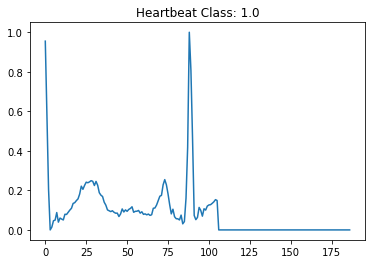

In [14]:
i = np.random.choice(X.shape[0])
plt.plot(X[i].flatten())
plt.title("Heartbeat Class: "+str(Y[i]))
plt.show()

In [15]:
pred_test = model.predict(X_test)
pred_test = (pred_test > 0.5).astype(np.int8)

f1 = f1_score(Y_test, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.9914691943127963 
Test accuracy score : 0.9876331157677773 


In [16]:
model.save("ptbdb.h5")